#BOTNET DETECTION


**LOADING OF THE DATASET**

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [2]:
!kaggle datasets download -d mrwellsdavid/unsw-nb15

 92% 137M/149M [00:01<00:00, 170MB/s]
100% 149M/149M [00:01<00:00, 145MB/s]


In [3]:
!unzip \*.zip && rm *.zip

Archive:  unsw-nb15.zip
  inflating: NUSW-NB15_features.csv  
  inflating: UNSW-NB15_1.csv         
  inflating: UNSW-NB15_2.csv         
  inflating: UNSW-NB15_3.csv         
  inflating: UNSW-NB15_4.csv         
  inflating: UNSW-NB15_LIST_EVENTS.csv  
  inflating: UNSW_NB15_testing-set.csv  
  inflating: UNSW_NB15_training-set.csv  


In [4]:
import warnings; warnings.simplefilter('ignore')
from sklearn.preprocessing import StandardScaler
import numpy as np 
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

**DATA PREPROCESSING**

In [5]:
train = pd.read_csv('UNSW_NB15_training-set.csv')
test = pd.read_csv('UNSW_NB15_testing-set.csv')
if train.shape[0]<100000:
    print("Train test sets are reversed. Fixing. ")
    train, test = test, train

# drop the unnecessory features from the dataset
drop_columns = ['attack_cat', 'id'] + ['response_body_len', 'spkts', 'ct_flw_http_mthd', 'trans_depth', 'dwin', 'ct_ftp_cmd', 'is_ftp_login']
for df in [train, test]:
    for col in drop_columns:
        if col in df.columns:
            print('Dropping '+col)
            df.drop([col], axis=1, inplace=True)

Train test sets are reversed. Fixing. 
Dropping attack_cat
Dropping id
Dropping response_body_len
Dropping spkts
Dropping ct_flw_http_mthd
Dropping trans_depth
Dropping dwin
Dropping ct_ftp_cmd
Dropping is_ftp_login
Dropping attack_cat
Dropping id
Dropping response_body_len
Dropping spkts
Dropping ct_flw_http_mthd
Dropping trans_depth
Dropping dwin
Dropping ct_ftp_cmd
Dropping is_ftp_login


In [6]:
train.head()

,dur,proto,service,state,dpkts,sbytes,dbytes,rate,sttl,dttl,...,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.121478,tcp,-,FIN,4,258,172,74.087490,252,254,...,1,0,1,1,1,1,1,1,0,0
1,0.649902,tcp,-,FIN,38,734,42014,78.473372,62,252,...,43,1,1,1,1,2,1,6,0,0
2,1.623129,tcp,-,FIN,16,364,13186,14.170161,62,252,...,7,1,2,1,1,3,2,6,0,0
3,1.681642,tcp,ftp,FIN,12,628,770,13.677108,62,252,...,1,1,2,1,1,3,2,1,0,0
4,0.449454,tcp,-,FIN,6,534,268,33.373826,254,252,...,43,1,2,2,1,40,2,39,0,0


In [7]:
#Converting less frequent data in the column to the others 
def feature_engineer(df):
    df.loc[~df['state'].isin(['FIN', 'INT', 'CON', 'REQ', 'RST']), 'state'] = 'others'
    df.loc[~df['service'].isin(['-', 'dns', 'http', 'smtp', 'ftp-data', 'ftp', 'ssh', 'pop3']), 'service'] = 'others'
    df.loc[df['proto'].isin(['igmp', 'icmp', 'rtp']), 'proto'] = 'igmp_icmp_rtp'
    df.loc[~df['proto'].isin(['tcp', 'udp', 'arp', 'ospf', 'igmp_icmp_rtp']), 'proto'] = 'others'
    return df

#Seperating categorical column form the non categorical column
def get_cat_columns(train):
    categorical = []
    for col in train.columns:
        if train[col].dtype == 'object':
            categorical.append(col)
    return categorical

In [8]:
x_train, y_train = train.drop(['label'], axis=1), train['label']
x_test, y_test = test.drop(['label'], axis=1), test['label']

x_train, x_test = feature_engineer(x_train), feature_engineer(x_test)

categorical_columns = get_cat_columns(x_train)
non_categorical_columns = [x for x in x_train.columns if x not in categorical_columns]

#feature scaling only applying on the non categorical data(numerical data)
scaler = StandardScaler()
x_train[non_categorical_columns] = scaler.fit_transform(x_train[non_categorical_columns])
x_test[non_categorical_columns] = scaler.transform(x_test[non_categorical_columns])



In [9]:
categorical_columns

['proto', 'service', 'state']

#Recursive feature elimination with cross-validation

In [10]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

# Initialize the estimator (in this case, a logistic regression model)
estimator = LogisticRegression()

# Initialize the RFE object with cross-validation
selector = RFECV(estimator, cv=5)

# Fit the selector to the training data
selector = selector.fit(x_train[non_categorical_columns], y_train)

# Get the selected features
selected_features = x_train[non_categorical_columns].columns[selector.support_]

# Print the selected features
print(selected_features)


Index(['dur', 'dpkts', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload',
       'sloss', 'dloss', 'sinpkt', 'dinpkt', 'djit', 'swin', 'tcprtt',
       'synack', 'ackdat', 'smean', 'dmean', 'ct_srv_src', 'ct_state_ttl',
       'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports'],
      dtype='object')


In [11]:
for df in [train, test]:
    for col in df.columns:
        if col != 'label' and col not in selected_features:
            print('Dropping ' + col)
            df.drop([col], axis=1, inplace=True)


Dropping proto
Dropping service
Dropping state
Dropping sbytes
Dropping sjit
Dropping stcpb
Dropping dtcpb
Dropping ct_src_ltm
Dropping proto
Dropping service
Dropping state
Dropping sbytes
Dropping sjit
Dropping stcpb
Dropping dtcpb
Dropping ct_src_ltm


#Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression

# Create a new logistic regression model
model = LogisticRegression(solver='liblinear', C=0.01)

# Train the model on the selected features
model.fit(x_train[selected_features], y_train)

# Evaluate the model on the test set
accuracy = model.score(x_test[selected_features], y_test)
print("Accuracy:", accuracy)


Accuracy: 0.7783850750619443


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Make predictions on the test set
y_pred = model.predict(x_test[selected_features])

# Calculate precision, recall, and F-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_score = f1_score(y_test, y_pred)

print('Precision:', precision)
print('Recall:', recall)
print('F-score:', f_score)


Precision: 0.7216240099495974
Recall: 0.9727565516632842
F-score: 0.8285794813979707


# K-Nearest Neighbors 

In [14]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train[selected_features], y_train)

accuracy = knn.score(x_test[selected_features], y_test)
print('Accuracy:', accuracy)


Accuracy: 0.8371107224408493


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Make predictions on the test set
y_pred = knn.predict(x_test[selected_features])

# Calculate precision, recall, and F-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_score = f1_score(y_test, y_pred)

print('Precision:', precision)
print('Recall:', recall)
print('F-score:', f_score)

Precision: 0.8040384798552243
Recall: 0.9310862084178947
F-score: 0.8629110572745766


#Random forest 

In [16]:
from sklearn.metrics import accuracy_score
model = RandomForestClassifier(n_estimators=50)

# Fit the model on the training data
model.fit(x_train[selected_features], y_train)

# Make predictions on the test data
y_pred = model.predict(x_test[selected_features])

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8707064082009425


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Make predictions on the test set
y_pred = model.predict(x_test[selected_features])

# Calculate precision, recall, and F-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_score = f1_score(y_test, y_pred)

print('Precision:', precision)
print('Recall:', recall)
print('F-score:', f_score)


Precision: 0.8187733196096091
Recall: 0.982683314215124
F-score: 0.8932714384543659


#GaussianNB

In [18]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Create a Gaussian Naive Bayes classifier
model = GaussianNB(var_smoothing=1e-6)

# Fit the model on the training data
model.fit(x_train[selected_features], y_train)

# Make predictions on the test data
y_pred = model.predict(x_test[selected_features])

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7371374435213526


In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Make predictions on the test set
y_pred = model.predict(x_test[selected_features])

# Calculate precision, recall, and F-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_score = f1_score(y_test, y_pred)

print('Precision:', precision)
print('Recall:', recall)
print('F-score:', f_score)

Precision: 0.6898724031803026
Recall: 0.9493735109856172
F-score: 0.7990827732184633


#Hybrid model 

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


# Instantiate the base classifiers
knn = KNeighborsClassifier(n_neighbors=7)
rf = RandomForestClassifier(n_estimators=50)

# Train the base classifiers
knn.fit(x_train[selected_features], y_train)
rf.fit(x_train[selected_features], y_train)

# Make predictions with the base classifiers
knn_preds = knn.predict(x_test[selected_features])
rf_preds = rf.predict(x_test[selected_features])

# Concatenate the predictions as new features
new_features = np.concatenate((knn_preds.reshape(-1,1), rf_preds.reshape(-1,1)), axis=1)

# Instantiate the meta-classifier
meta = LogisticRegression(C=0.01)

# Train the meta-classifier on the new features
meta.fit(new_features, y_test)

# Make predictions with the hybrid model
hybrid_preds = meta.predict(new_features)

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Evaluate the hybrid model
accuracy = accuracy_score(y_test, hybrid_preds)
precision = precision_score(y_test, hybrid_preds)
recall = recall_score(y_test, hybrid_preds)
f1 = f1_score(y_test, hybrid_preds)

# Print the evaluation metrics for the hybrid model
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8688966622941262
Precision: 0.817199955916388
Recall: 0.9814259242918909
F1-score: 0.8918155030368633


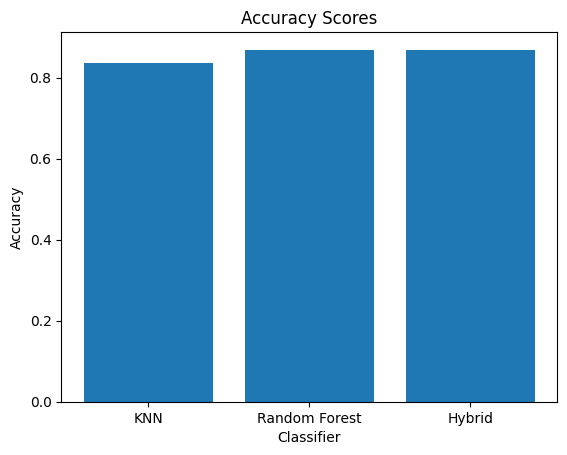

In [22]:
import matplotlib.pyplot as plt

# Define the labels and values for the graph
labels = ['KNN', 'Random Forest', 'Hybrid']
values = [accuracy_score(y_test, knn_preds), accuracy_score(y_test, rf_preds), accuracy_score(y_test, hybrid_preds)]

# Create a bar graph
plt.bar(labels, values)

# Set the title and axis labels
plt.title('Accuracy Scores')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')

# Display the graph
plt.show()


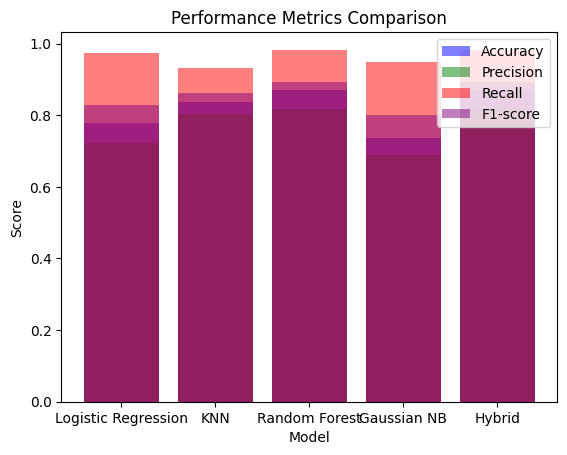

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Create a list of models
models = ['Logistic Regression', 'KNN', 'Random Forest', 'Gaussian NB', 'Hybrid']

# Create empty lists to store the performance metrics
acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

# Evaluate each model and store its performance metrics
for model in [LogisticRegression(solver='liblinear', C=0.01), 
              KNeighborsClassifier(n_neighbors=7), 
              RandomForestClassifier(n_estimators=50), 
              GaussianNB(var_smoothing=1e-6), 
              meta]:
    if model == meta:
        model_preds = hybrid_preds
    else:
        model.fit(x_train[selected_features], y_train)
        model_preds = model.predict(x_test[selected_features])
        
    acc_scores.append(accuracy_score(y_test, model_preds))
    prec_scores.append(precision_score(y_test, model_preds))
    rec_scores.append(recall_score(y_test, model_preds))
    f1_scores.append(f1_score(y_test, model_preds))

# Create a bar graph for each performance metric
plt.bar(models, acc_scores, color='blue', alpha=0.5, label='Accuracy')
plt.bar(models, prec_scores, color='green', alpha=0.5, label='Precision')
plt.bar(models, rec_scores, color='red', alpha=0.5, label='Recall')
plt.bar(models, f1_scores, color='purple', alpha=0.5, label='F1-score')

# Set the title and axis labels
plt.title('Performance Metrics Comparison')
plt.xlabel('Model')
plt.ylabel('Score')

# Add a legend and display the graph
plt.legend()
plt.show()


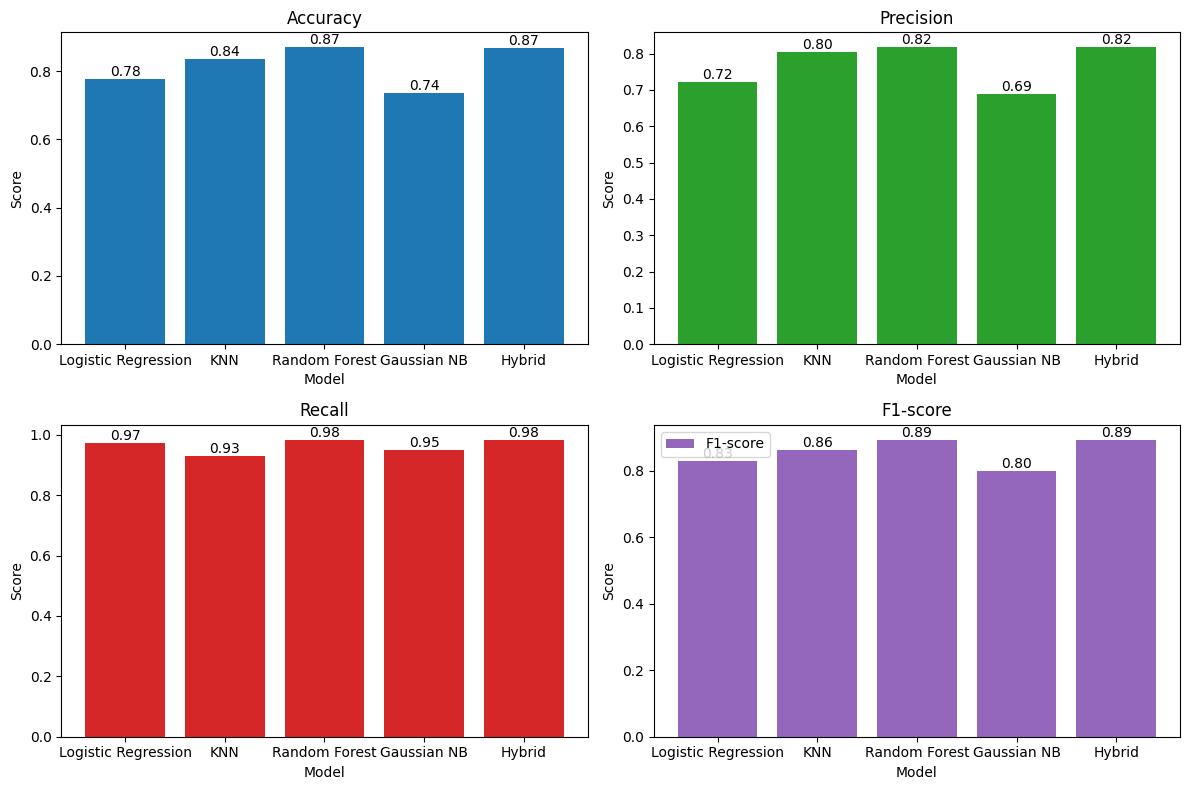

<Figure size 640x480 with 0 Axes>

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Create a list of models
models = ['Logistic Regression', 'KNN', 'Random Forest', 'Gaussian NB', 'Hybrid']

# Create empty lists to store the performance metrics
acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

# Evaluate each model and store its performance metrics
for model in [LogisticRegression(solver='liblinear', C=0.01),    
              KNeighborsClassifier(n_neighbors=7),          
              RandomForestClassifier(n_estimators=50),         
              GaussianNB(var_smoothing=1e-6),        
              meta]:
    if model == meta:
        model_preds = hybrid_preds
    else:
        model.fit(x_train[selected_features], y_train)
        model_preds = model.predict(x_test[selected_features])
        
    acc_scores.append(accuracy_score(y_test, model_preds))
    prec_scores.append(precision_score(y_test, model_preds))
    rec_scores.append(recall_score(y_test, model_preds))
    f1_scores.append(f1_score(y_test, model_preds))

# Create a figure with 4 subplots for each performance metric
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Set the title and axis labels for each subplot
ax1.set_title('Accuracy')
ax1.set_xlabel('Model')
ax1.set_ylabel('Score')
ax2.set_title('Precision')
ax2.set_xlabel('Model')
ax2.set_ylabel('Score')
ax3.set_title('Recall')
ax3.set_xlabel('Model')
ax3.set_ylabel('Score')
ax4.set_title('F1-score')
ax4.set_xlabel('Model')
ax4.set_ylabel('Score')

# Set the color scheme for each performance metric
colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd']

# Plot a bar graph for each performance metric
ax1.bar(models, acc_scores, color=colors[0], label='Accuracy')
ax2.bar(models, prec_scores, color=colors[1], label='Precision')
ax3.bar(models, rec_scores, color=colors[2], label='Recall')
ax4.bar(models, f1_scores, color=colors[3], label='F1-score')

# Add text labels for each individual bar
for i, model in enumerate(models):
    ax1.text(i, acc_scores[i], "{:.2f}".format(acc_scores[i]), ha='center', va='bottom')
    ax2.text(i, prec_scores[i], "{:.2f}".format(prec_scores[i]), ha='center', va='bottom')
    ax3.text(i, rec_scores[i], "{:.2f}".format(rec_scores[i]), ha='center', va='bottom')
    ax4.text(i, f1_scores[i], "{:.2f}".format(f1_scores[i]), ha='center', va='bottom')

# Add a legend and display the graph
plt.legend()
plt.tight_layout()
plt.show()

# Export the graph to a PNG file
plt.savefig('performance_metrics_comparison.png')


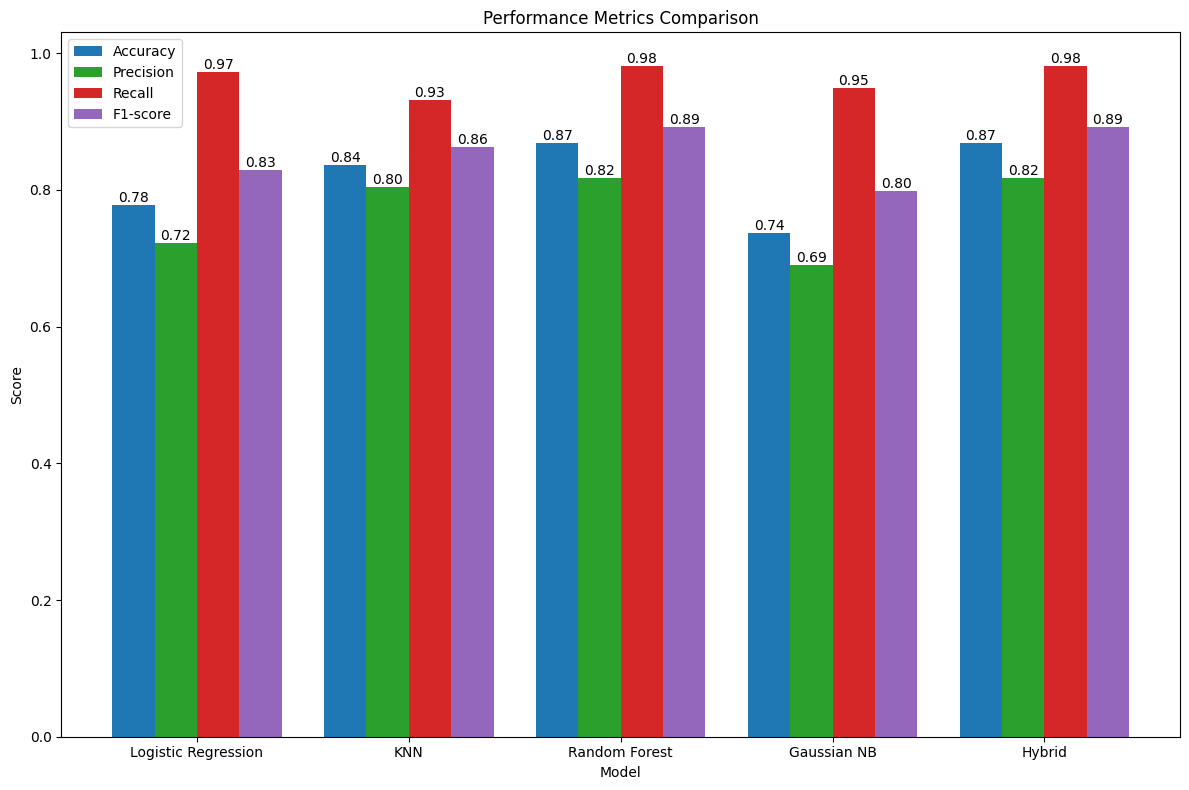

<Figure size 640x480 with 0 Axes>

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Create a list of models
models = ['Logistic Regression', 'KNN', 'Random Forest', 'Gaussian NB', 'Hybrid']

# Create empty lists to store the performance metrics
acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

# Evaluate each model and store its performance metrics
for model in [LogisticRegression(solver='liblinear', C=0.01),    
              KNeighborsClassifier(n_neighbors=7),          
              RandomForestClassifier(n_estimators=50),         
              GaussianNB(var_smoothing=1e-6),        
              meta]:
    if model == meta:
        model_preds = hybrid_preds
    else:
        model.fit(x_train[selected_features], y_train)
        model_preds = model.predict(x_test[selected_features])
        
    acc_scores.append(accuracy_score(y_test, model_preds))
    prec_scores.append(precision_score(y_test, model_preds))
    rec_scores.append(recall_score(y_test, model_preds))
    f1_scores.append(f1_score(y_test, model_preds))

# Create a figure with a single subplot for all performance metrics
fig, ax = plt.subplots(figsize=(12, 8))

# Set the title and axis labels
ax.set_title('Performance Metrics Comparison')
ax.set_xlabel('Model')
ax.set_ylabel('Score')

# Set the color scheme for each performance metric
colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd']

# Plot a bar graph for each performance metric
ax.bar(np.arange(len(models)) - 0.3, acc_scores, width=0.2, color=colors[0], label='Accuracy')
ax.bar(np.arange(len(models)) - 0.1, prec_scores, width=0.2, color=colors[1], label='Precision')
ax.bar(np.arange(len(models)) + 0.1, rec_scores, width=0.2, color=colors[2], label='Recall')
ax.bar(np.arange(len(models)) + 0.3, f1_scores, width=0.2, color=colors[3], label='F1-score')

# Add text labels for each individual bar
for i, model in enumerate(models):
    ax.text(i - 0.3, acc_scores[i], "{:.2f}".format(acc_scores[i]), ha='center', va='bottom')
    ax.text(i - 0.1, prec_scores[i], "{:.2f}".format(prec_scores[i]), ha='center', va='bottom')
    ax.text(i + 0.1, rec_scores[i], "{:.2f}".format(rec_scores[i]), ha='center', va='bottom')
    ax.text(i + 0.3, f1_scores[i], "{:.2f}".format(f1_scores[i]), ha='center', va='bottom')

# Set the x-axis tick labels to be the model names
ax.set_xticks(np.arange(len(models)))
ax.set_xticklabels(models)

# Add a legend and display the graph
plt.legend()
plt.tight_layout()
plt.show()

# Export the graph to a PNG file
plt.savefig('performance_metrics_comparison.png')
